In [449]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os 
from glob import glob 
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cbook as cbook

## Preprocessing 

In [234]:
SEG_OUTPUT = "/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Output/Chain_05.02/seg"
BVAP_OUTPUT ='/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Output/Chain_05.02/bvap'

seg_pattern = os.path.join(SEG_OUTPUT, 'RunTwo' + '_segregation' + '*')
bvap_pattern = os.path.join(BVAP_OUTPUT, 'RunTwo' + '_bvap' + '*')

seg_files = glob(seg_pattern)
bvap_files = glob(bvap_pattern)

In [278]:
# double check all the seeds (seg)

# get the seeds
seg_seeds = [x.split('_')[3] for x in seg_files]
bvap_seeds = [x.split('_')[3] for x in bvap_files]
# seeds that are in both seg and bvap files
all_seeds = list(set(seg_seeds) & set(bvap_seeds))


In [284]:
# get only the files with matching bvap scores
reduced_seg_files = [seg_files[seg_seeds.index(all_seeds[i])] for i in range(len(all_seeds))]
reduced_bvap_files = [bvap_files[bvap_seeds.index(all_seeds[i])] for i in range(len(all_seeds))]

In [286]:
# they match 
len(reduced_bvap_files), len(reduced_seg_files) 

(354, 354)

In [298]:
# making sure there are no duplicate files 
seg_seeds_2 = [x.split('_')[3] for x in reduced_seg_files]
counts = [seg_seeds_2.count(y) for y in seg_seeds_2]
idx = [i for i, value in enumerate(counts) if value == 2]
idx

[]

In [302]:
n=len(reduced_seg_files)*2000
seg_scores = [np.zeros(n) for i in range(7)]
bvap_scores = [np.zeros(n) for i in range(7)]

In [305]:
# Get arrays of scores indexted lowest to highest
# the last and first iteration of each map are the same, so we need to drop the last row of every file 

for i, file in enumerate(reduced_seg_files):
    df = pd.read_csv(file,names=[1,2,3,4,5,6,7])
    df = df.transpose()
    df = pd.DataFrame(np.sort(df.values, axis=0), index=df.index, columns=df.columns)
    df = df.drop(2000, axis=1)
    for j in range(7):
        seg_scores[j][0+1999*i:1999+1999*i] = df.iloc[j]

[np.mean(seg_scores[i]) for i in range(7)]

In [327]:
for i, file in enumerate(reduced_bvap_files):
    df = pd.read_csv(reduced_bvap_files[0])
    df = df.transpose()
    df = pd.DataFrame(np.sort(df.values, axis=0), index=df.index, columns=df.columns)
    df = df.drop(1999, axis=1)
    for j in range(7):
        bvap_scores[j][0+1999*i:1999+1999*i] = df.iloc[j]



## Graph Settings

In [330]:
## Boxplot Settings ====================

# Number of iterations to compare for each set of boxes
#steps = [100, 1000, 10000]
n_trials = n
n_dists = 7

n_steps = 5
steps = np.logspace(2, np.log10(n_trials), n_steps).astype(int)

# Settings for whiskers

# Default - 1.5 of IQR
whis = 1.5

# 1st and 99th percentiles
#whis = [1, 99]

# Min and max
#whis = [0, 100]

# Boxplot properties
#      more examples: https://matplotlib.org/3.1.1/gallery/statistics/boxplot.html

flierprops = dict(marker='.', 
                  markersize=0) # Setting to 0 turns fliers off

medianprops = dict(linestyle='-',
                   color='k')

boxprops = dict(color='k')

## KDE settings

# Have the opportunity to get more granular here
n_steps_kde = 10
kde_steps = np.logspace(2, np.log10(n_trials), n_steps_kde).astype(int)


In [332]:
colors = ['cornflowerblue','teal','red','darkorange','rebeccapurple']

import matplotlib.patches as mpatches

patch_1 = mpatches.Patch(color='cornflowerblue', label=str(steps[0]))
patch_2 = mpatches.Patch(color='teal', label=str(steps[1]))
patch_3 = mpatches.Patch(color='red', label=str(steps[2]))
patch_4 = mpatches.Patch(color='darkorange', label=str(steps[3]))
patch_5 = mpatches.Patch(color='rebeccapurple', label=str(steps[4]))

## Segregation Convergence Plots

In [333]:
# 1_100, 2_100, 3_100... 1_1000000, 2_1000000... 
stats = []
for s in steps:
    for i in range(7):
        stats.append(cbook.boxplot_stats(seg_scores[i][0:s], whis = whis)[0])

In [334]:
pos = np.arange(0, n_dists)
box_pos = len(steps)*pos + 1
box_pos += range(len(box_pos))

# Position for the x-axis tick labels (in the middle of each districts group of boxes)
tick_pos = box_pos + (len(steps)+1)/2 - 1

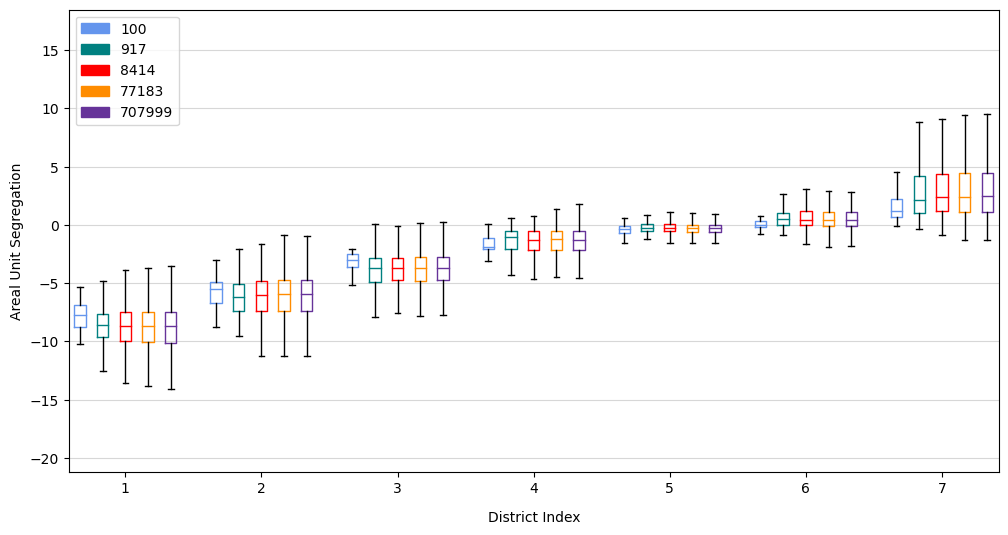

In [336]:
fig, ax = plt.subplots(figsize=(12,6))
# Looping over each subset of data (e.g, 100 trials, 1000 trials, etc.)
for i,s in enumerate(steps):
    data = stats[0+7*i:7+7*i]
    # Create the boxplots
    ax.bxp(data, positions = box_pos+i, 
           widths=0.5,
           boxprops = dict(color=colors[i]),
           flierprops = flierprops,
           medianprops = dict(linestyle='-',
                   color=colors[i])
          )
    pos = pos+6

plt.xticks(tick_pos, [1,2,3,4,5,6,7], rotation=0)
plt.ylabel('Areal Unit Segregation')
plt.text(19,-25.5, 'District Index')
plt.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], loc='upper left')
#plt.savefig('convergence_bars')
plt.grid(axis='y',alpha=.5)
plt.show()

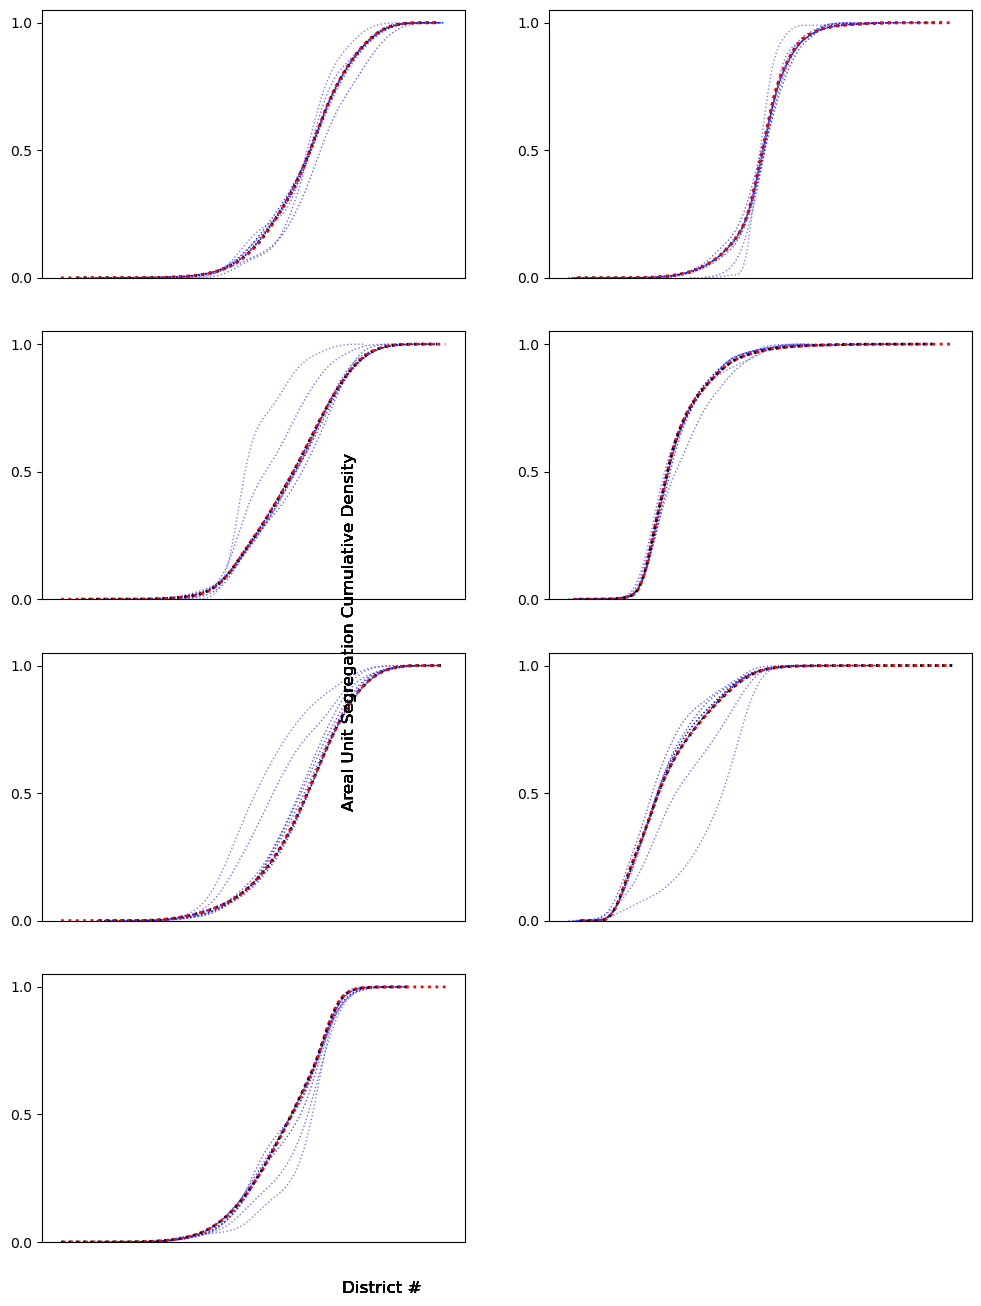

In [210]:
# Showing convergence for individual districts as overlaid cumulative KDE plots

fig, ax = plt.subplots(4,2, figsize=(12,16))
fig.delaxes(ax[3,1])

p=0
q=0

for j in range(0,7):

    temp = seg_scores[j]
    alphas = np.linspace(0.5, 1, len(kde_steps))

    x = 1

    for i,s in enumerate(kde_steps):
        
        # Show smaller samples as thin blue dotted with varying alpha
        # Show final two as dotted black and dotted red, thick
        
        if i == (len(kde_steps)-1):
            linestyle=':'
            color = 'r'
            linewidth = 2
            alpha = 1
        elif i == (len(kde_steps)-2):
            linestyle=':'
            color = 'k'
            linewidth = 2
            alpha = 1
        else:
            linestyle=':'
            color = 'b'
            linewidth = 1
            alpha = alphas[i]

        sns.kdeplot(temp[0:s], 
                    ax = ax[p,q],
                    color = color, 
                    alpha = alpha, 
                    linestyle = linestyle,
                    linewidth = linewidth, 
                    cumulative=True)

        ax[p,q].set_xticks([])
        ax[p,q].set_yticks([0,.5,1])
        ax[p,q].set_ylabel("")
    
    p+=1

    if p==4:
        p=0
        q=1

    plt.text(0,-.2,'District #',fontsize=12)
    plt.text(0,1.7,'Areal Unit Segregation Cumulative Density',fontsize=12, rotation='vertical')
    #plt.legend(handles=[patch_6, patch_7], bbox_to_anchor=(1.52, .8), loc='lower right')

#plt.savefig('convergence districts')
plt.show()

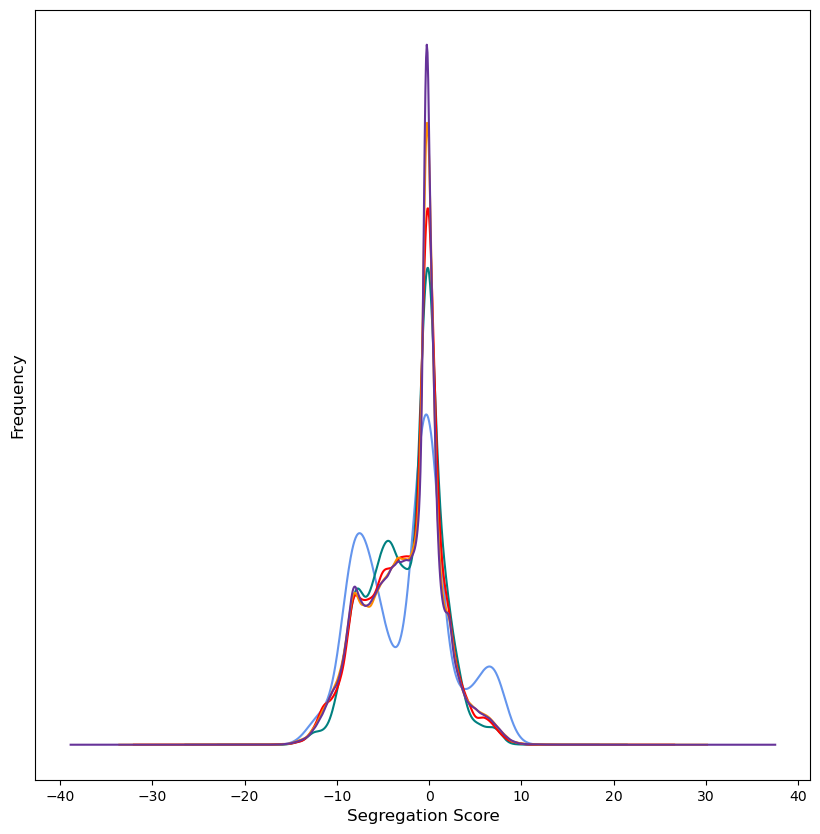

In [211]:
fig1, ax1 = plt.subplots(figsize=(10,10))

pd.DataFrame(np.concatenate([seg_scores[i][:steps[0]] for i in range(7)])).plot(kind='density', 
                                                                          ax=ax1, 
                                                                          color=colors[0],
                                                                          legend=False)

pd.DataFrame(np.concatenate([seg_scores[i][:steps[1]] for i in range(7)])).plot(kind='density', 
                                                                          ax=ax1, 
                                                                          color=colors[1],
                                                                          legend=False)

pd.DataFrame(np.concatenate([seg_scores[i][:steps[2]] for i in range(7)])).plot(kind='density', 
                                                                          ax=ax1, 
                                                                          color=colors[2],
                                                                          legend=False)

pd.DataFrame(np.concatenate([seg_scores[i][:steps[3]] for i in range(7)])).plot(kind='density', 
                                                                          ax=ax1, 
                                                                          color=colors[3],
                                                                          legend=False)

pd.DataFrame(np.concatenate([seg_scores[i][:steps[4]] for i in range(7)])).plot(kind='density', 
                                                                          ax=ax1, 
                                                                          color=colors[4],
                                                                          legend=False)

#plt.legend(labels=["30,000 Iterations", "60,000 Iterations", "90,000 Iterations", "120,000 Iterations", "150,000 Iterations"],
           # prop={'size':12})
ax1.set_xlabel("Segregation Score", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_yticks([])

#plt.savefig("line_compare")
plt.show()

## BVAP Convergence Plots

In [342]:
# 1_100, 2_100, 3_100... 1_1000000, 2_1000000... 
bvap_stats = []
for s in steps:
    for i in range(7):
        bvap_stats.append(cbook.boxplot_stats(bvap_scores[i][0:s], whis = whis)[0])

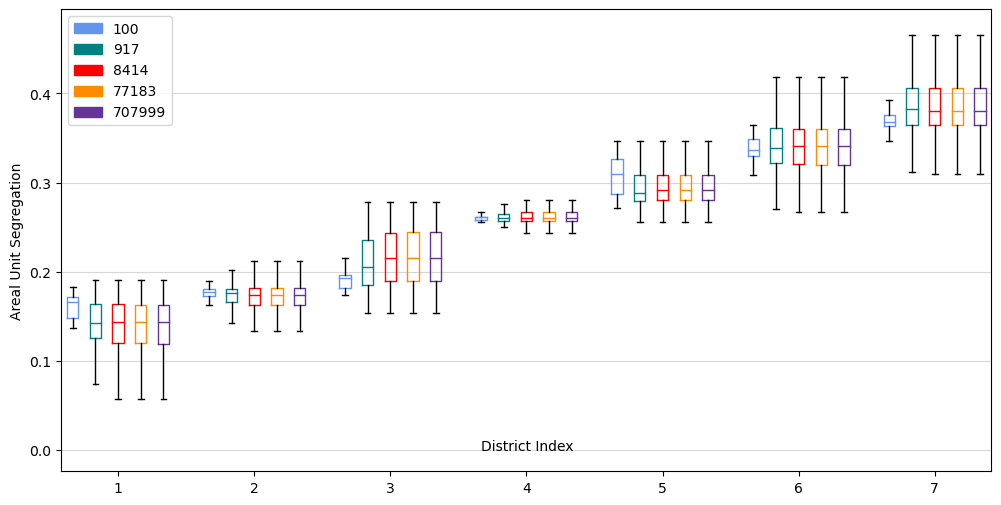

In [344]:
fig, ax = plt.subplots(figsize=(12,6))
# Looping over each subset of data (e.g, 100 trials, 1000 trials, etc.)
for i,s in enumerate(steps):
    data = bvap_stats[0+7*i:7+7*i]
    # Create the boxplots
    ax.bxp(data, positions = box_pos+i, 
           widths=0.5,
           boxprops = dict(color=colors[i]),
           flierprops = flierprops,
           medianprops = dict(linestyle='-',
                   color=colors[i])
          )
    pos = pos+6

plt.xticks(tick_pos, [1,2,3,4,5,6,7], rotation=0)
plt.ylabel('Areal Unit Segregation')
plt.text(19,0, 'District Index')
plt.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], loc='upper left')
#plt.savefig('convergence_bars')
plt.grid(axis='y',alpha=.5)
plt.show()

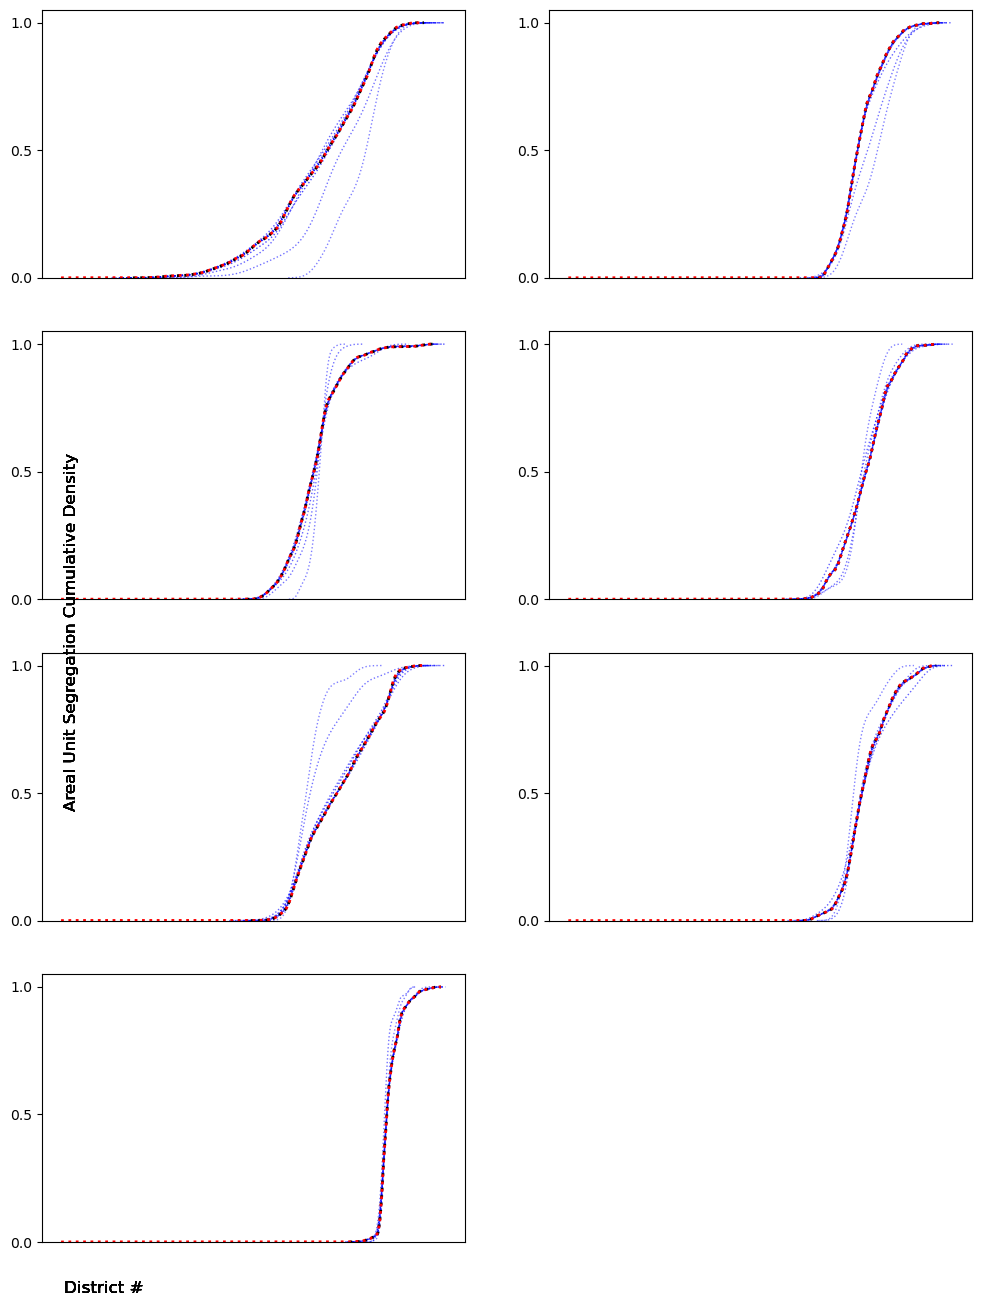

In [345]:
# Showing convergence for individual districts as overlaid cumulative KDE plots

fig, ax = plt.subplots(4,2, figsize=(12,16))
fig.delaxes(ax[3,1])

p=0
q=0

for j in range(0,7):

    temp = bvap_scores[j]
    alphas = np.linspace(0.5, 1, len(kde_steps))

    x = 1

    for i,s in enumerate(kde_steps):
        
        # Show smaller samples as thin blue dotted with varying alpha
        # Show final two as dotted black and dotted red, thick
        
        if i == (len(kde_steps)-1):
            linestyle=':'
            color = 'r'
            linewidth = 2
            alpha = 1
        elif i == (len(kde_steps)-2):
            linestyle=':'
            color = 'k'
            linewidth = 2
            alpha = 1
        else:
            linestyle=':'
            color = 'b'
            linewidth = 1
            alpha = alphas[i]

        sns.kdeplot(temp[0:s], 
                    ax = ax[p,q],
                    color = color, 
                    alpha = alpha, 
                    linestyle = linestyle,
                    linewidth = linewidth, 
                    cumulative=True)

        ax[p,q].set_xticks([])
        ax[p,q].set_yticks([0,.5,1])
        ax[p,q].set_ylabel("")
    
    p+=1

    if p==4:
        p=0
        q=1

    plt.text(0,-.2,'District #',fontsize=12)
    plt.text(0,1.7,'Areal Unit Segregation Cumulative Density',fontsize=12, rotation='vertical')
    #plt.legend(handles=[patch_6, patch_7], bbox_to_anchor=(1.52, .8), loc='lower right')

#plt.savefig('convergence districts')
plt.show()

## Analysis

In [399]:
original_seg_scores = list(pd.read_csv(seg_files[seg_seeds.index('1')], names=[1,2,3,4,5,6,7]).iloc[0])
original_seg_scores.sort()
original_bvap_scores = list(pd.read_csv('/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Output/Chain_05.02/bvap/RunTwo_bvap_1').iloc[0])
original_bvap_scores.sort()


In [401]:
all_seg_stats = []
for i in range(7):
    all_seg_stats.append(cbook.boxplot_stats(seg_scores[i], whis = whis)[0])

all_bvap_stats = []
for i in range(7):
    all_bvap_stats.append(cbook.boxplot_stats(bvap_scores[i], whis = whis)[0])


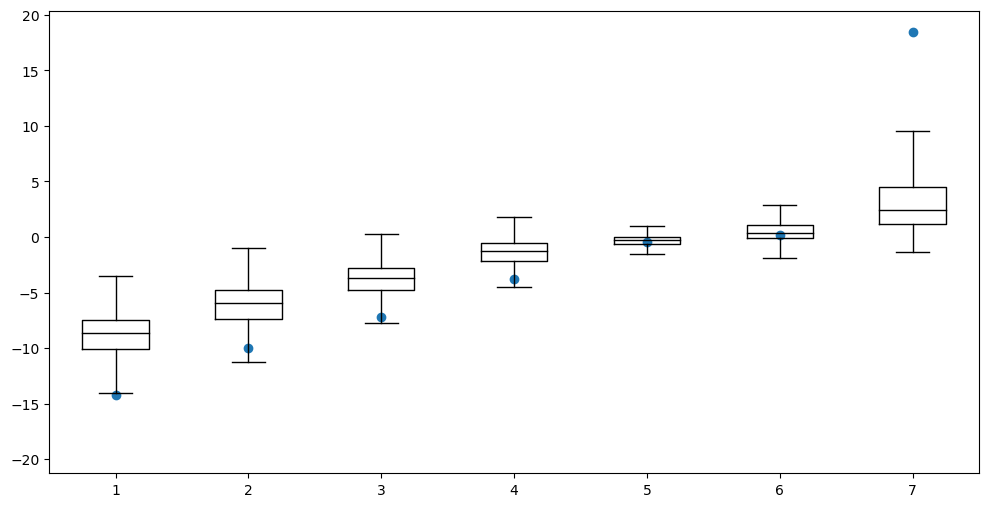

In [392]:
fig, ax = plt.fig, ax = plt.subplots(figsize=(12,6))

ax.bxp(all_seg_stats, positions = [1,2,3,4,5,6,7], 
           widths=0.5,
           boxprops = dict(color='black'),
           flierprops = flierprops,
           medianprops = dict(linestyle='-',
                   color='black'))

plt.scatter(x=[1,2,3,4,5,6,7],y=original_seg_scores)

plt.show()

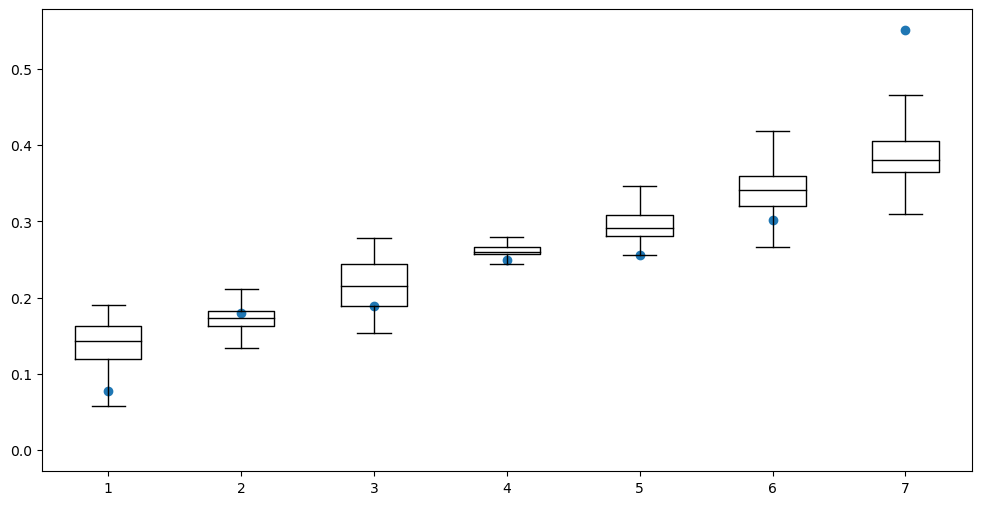

In [402]:
fig, ax = plt.fig, ax = plt.subplots(figsize=(12,6))

ax.bxp(all_bvap_stats, positions = [1,2,3,4,5,6,7], 
           widths=0.5,
           boxprops = dict(color='black'),
           flierprops = flierprops,
           medianprops = dict(linestyle='-',
                   color='black'))

plt.scatter(x=[1,2,3,4,5,6,7],y=original_bvap_scores)

plt.show()

## Standardize?

In [404]:
from sklearn.preprocessing import StandardScaler as SS


In [423]:
seg_scores_flat =  [item for list in seg_scores for item in list]

ss = SS()
ss.fit(pd.DataFrame(seg_scores_flat))

In [441]:
bvap_scores_flat = [item for list in bvap_scores for item in list]

ss = SS()
ss.fit(pd.DataFrame(bvap_scores_flat))

bvap_scores_s = []
for score in bvap_scores:
    bvap_scores_s.append(ss.transform(pd.DataFrame(score)).flatten())

In [434]:
seg_scores_s = []
for list in seg_scores:
    seg_scores_s.append(ss.transform(pd.DataFrame(list)).flatten())

In [443]:
seg_s_stats = []
for i in range(7):
    seg_s_stats.append(cbook.boxplot_stats(seg_scores_s[i], whis = whis)[0])

bvap_s_stats = []
for i in range(7):
    bvap_s_stats.append(cbook.boxplot_stats(bvap_scores_s[i], whis = whis)[0])

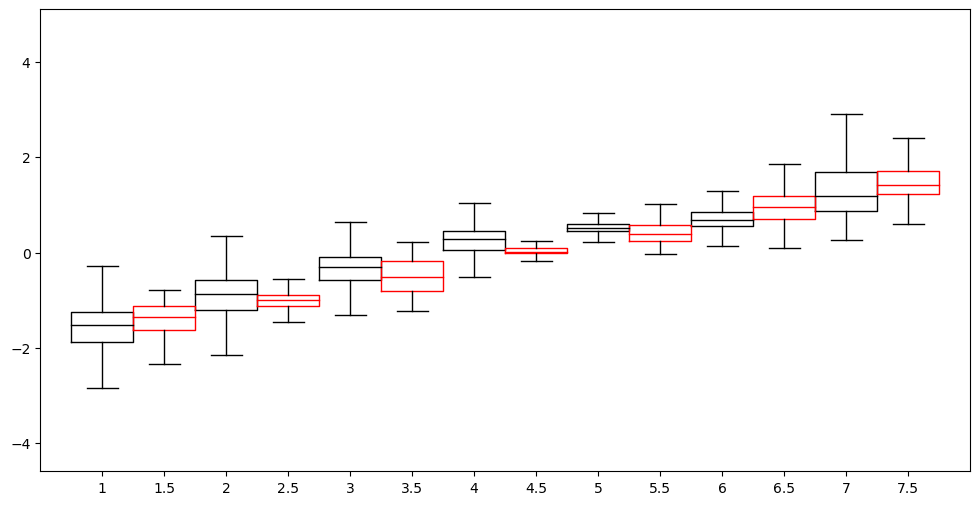

In [445]:
fig, ax = plt.fig, ax = plt.subplots(figsize=(12,6))

ax.bxp(seg_s_stats, positions = [1,2,3,4,5,6,7], 
           widths=0.5,
           boxprops = dict(color='black'),
           flierprops = flierprops,
           medianprops = dict(linestyle='-',
                   color='black'))

ax.bxp(bvap_s_stats, positions = [1.5,2.5,3.5,4.5,5.5,6.5,7.5], 
           widths=0.5,
           boxprops = dict(color='red'),
           flierprops = flierprops,
           medianprops = dict(linestyle='-',
                   color='red'))

plt.show()

## Maps

In [458]:
SHP = '/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Data/State Shp Files/AL/Alabama_VTD_District_Intersection.shp'

gdf = gpd.read_file(SHP)
gdf["incumbent"] = gdf["incumbent"].fillna(0)

pattern = os.path.join('/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Output/Chain_05.02/used', 'RunTwo' + '_assignments' + '*')
pattern_2 = os.path.join('/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Output/Chain_05.02/run', 'RunTwo' + '_assignments' + '*')
files = glob(pattern) + glob(pattern_2)

In [472]:
assignment_seeds = [x.split('_')[3] for x in files]
onethree = files[assignment_seeds.index('1.3')]
onethreeseven = files[assignment_seeds.index('1.3.7')]
onethreeeight = files[assignment_seeds.index('1.3.8')]


In [487]:
def plot_map(file, map_num = int):

    data = pd.read_csv(file).set_index('Iteration').reset_index()

    gdf['cd_117'] = data[str(map_num)]
    gdf.plot(column="cd_117")
    plt.axis('off')
    plt.txt('seed, map_num')


AttributeError: module 'matplotlib.pyplot' has no attribute 'txt'

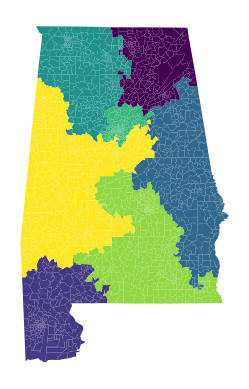

In [488]:
plot_map(onethree, 2000)

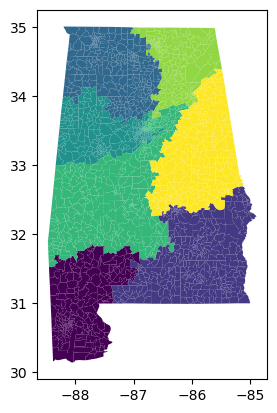

In [482]:
plot_map(onethreeseven,100)

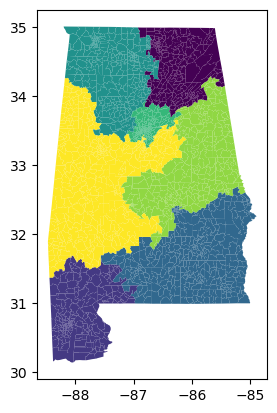

In [480]:
plot_map(onethreeeight,2)

## Black Majority

In [492]:
meta_path = os.path.join('/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Output/Chain_05.02/meta', 'RunTwo' + '_metadata' + '*')
meta_files = glob(meta_path)

In [499]:
len(meta_files)

728

In [503]:
black_majority = np.zeros(len(meta_files) * 2000)

for i, files in enumerate(meta_files):
    black_majority[0+2000*i:2000+2000*i] = pd.read_csv(meta_files[0],index_col='Iteration').loc['black_majority']

In [511]:
set(black_majority)

{0.0, 1.0}